In [1]:
import requests
import pandas as pd
import pickle

In [4]:
#url='https://production-media.paperswithcode.com/about/papers-with-abstracts.json.gz'
df = pd.read_json('papers-with-abstracts.json.gz')

In [28]:
def normalize_conf(x):
    if not isinstance(x, str):
        return None
    for c in ['NeurIPS', 'CVPR', 'ICCV', 'ECCV', 'ICLR', 'ACL', 'ICML', 'LREC', 
              'EMNLP', 'COLING', 'IJCNLP', 'WS ', 'SEMEVAL', 'RANLP', 'JEPTALNRECITAL']:
        if c.lower() in x.lower():
            return c.strip()
    return None

In [29]:
df['conf'] = df.proceeding.apply(lambda x:normalize_conf(x))

In [34]:
df_conf = df[~pd.isnull(df.conf)]
len(df_conf)

89120

In [62]:
authors = {}
for row in df_conf.itertuples():
    for a in row.authors:
        if a in ['Anonymous', ''] or len(a)<5:
            continue
        if a not in authors:
            authors[a] = {'total': 0, 'author': a}
        if row.conf not in authors[a]:
            authors[a][row.conf] = 0
        authors[a][row.conf] += 1
        authors[a]['total'] += 1
            

In [81]:
df_authors = pd.DataFrame(sorted(authors.values(), key=lambda x:x['total'], reverse=True))

In [83]:
df_authors = df_authors[df_authors.total>5]

In [84]:
df_authors[df_authors.author=='Yann Lecun']

,total,author,NeurIPS,ACL,CVPR,ECCV,EMNLP,IJCNLP,ICLR,WS,COLING,LREC,ICCV,SEMEVAL,ICML,RANLP,JEPTALNRECITAL
1036,33,Yann Lecun,12.0,2.0,6.0,1.0,NaN,NaN,5.0,NaN,NaN,NaN,4.0,NaN,3.0,NaN,NaN


In [101]:
def get_institution(x):
    r = requests.get(f'https://api.openalex.org/authors?search={x}').json()
    res = r['results']
    ans = {}
    if res:
        if 'affiliations' in res[0] and res[0]['affiliations']:
            ans['affiliations'] = res[0]['affiliations']
            if res[0]['affiliations'][0] and 'institution' in res[0]['affiliations'][0]:
                ans['last_affiliation'] = res[0]['affiliations'][0]['institution']['display_name']
                ans['last_affiliation_country'] = res[0]['affiliations'][0]['institution']['country_code']
        if 'orcid' in res[0]:
            ans['orcid'] = res[0]['orcid']
    return ans
    

In [213]:
#get_institution('Yann Lecun')

In [103]:
openalex_data = {}

In [111]:
ix = 0
for row in df_authors.itertuples():
    if row.author not in openalex_data:
        openalex_data[row.author] = get_institution(row.author)
    ix += 1
    if ix%10==0:
        print(ix, end=',')

10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,510,520,530,540,550,560,570,580,590,600,610,620,630,640,650,660,670,680,690,700,710,720,730,740,750,760,770,780,790,800,810,820,830,840,850,860,870,880,890,900,910,920,930,940,950,960,970,980,990,1000,1010,1020,1030,1040,1050,1060,1070,1080,1090,1100,1110,1120,1130,1140,1150,1160,1170,1180,1190,1200,1210,1220,1230,1240,1250,1260,1270,1280,1290,1300,1310,1320,1330,1340,1350,1360,1370,1380,1390,1400,1410,1420,1430,1440,1450,1460,1470,1480,1490,1500,1510,1520,1530,1540,1550,1560,1570,1580,1590,1600,1610,1620,1630,1640,1650,1660,1670,1680,1690,1700,1710,1720,1730,1740,1750,1760,1770,1780,1790,1800,1810,1820,1830,1840,1850,1860,1870,1880,1890,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100,2110,2120,2130,2140,2150,2160,2170,2180,2190,2200,2210,222

In [116]:
#
#pickle.dump(openalex_data, open('openalex_data.pickle', 'wb'))

In [115]:
data_from_openalex = pickle.load(open('openalex_data.pickle', 'rb'))
len(data_from_openalex)

12601

In [157]:
organismes=['French National Centre for Scientific Research',
           'Inserm', 'French Institute for Research in Computer Science and Automation',
            'Atomic Energy and Alternative Energies Commission',
 'National Research Institute for Agriculture, Food and Environment',
           ]

def get_preferred_affiliation(affiliations):
    for a in affiliations:
        if a.get('institution', {}).get('display_name') in organismes:
            continue
        skip = False
        if a.get('institution', {}).get('display_name'):
            for k in ['Département', 'Laboratoire', 'Langues', 'Valeo', 'Laboratory', 
                      'Corpus', 'Centre de Recherche', 'Centre de Mathématiques', 'Computer Processing',
                     'CEA LIST', 'inria', 'INRIA', 'Institute of Computer Science',
                     'Institut de Recherche en Informatique']:
                if k in a.get('institution', {}).get('display_name'):
                    skip=True
        if skip is False:
            return a.get('institution', {}).get('display_name')
    return affiliations[0]['institution']['display_name']

In [158]:
df_authors['orcid']=''
df_authors['last_affiliation']=''
df_authors['last_affiliation_country']=''

for ix, row in df_authors.iterrows():
    if row.author in data_from_openalex:
        current_info = data_from_openalex[row.author]
        if current_info:
            df_authors.at[ix, 'orcid'] = current_info.get('orcid')
            df_authors.at[ix, 'last_affiliation'] = current_info.get('last_affiliation')
            df_authors.at[ix, 'last_affiliation_country'] = current_info.get('last_affiliation_country')
            if current_info.get('last_affiliation_country') == 'FR':
                df_authors.at[ix, 'last_affiliation'] = get_preferred_affiliation(current_info['affiliations'])

In [167]:
df_authors['total_top15_conferences'] = df_authors['total']
del df_authors['total']

In [170]:
df_authors = df_authors[['author', 'total_top15_conferences', 'last_affiliation', 'NeurIPS', 'ACL', 'CVPR', 'ECCV', 'EMNLP', 'IJCNLP',
       'ICLR', 'WS', 'COLING', 'LREC', 'ICCV', 'SEMEVAL', 'ICML', 'RANLP',
       'JEPTALNRECITAL', 'orcid',
       'last_affiliation_country']]

In [171]:
df_authors_fr = df_authors[df_authors.last_affiliation_country=='FR'].fillna(0)

In [172]:
df_authors_fr.to_csv('authors_fr_top_conferences.csv', index=False)

In [173]:
df_authors_fr.head(15)

,author,total_top15_conferences,last_affiliation,NeurIPS,ACL,CVPR,ECCV,EMNLP,IJCNLP,ICLR,WS,COLING,LREC,ICCV,SEMEVAL,ICML,RANLP,JEPTALNRECITAL,orcid,last_affiliation_country
83,Cordelia Schmid,98,École Normale Supérieure - PSL,13.0,0.0,37.0,12.0,0.0,0.0,2.0,0.0,0.0,0.0,33.0,0.0,1.0,0.0,0.0,0,FR
249,Laurent Besacier,65,Université Grenoble Alpes,0.0,10.0,0.0,0.0,8.0,0.0,0.0,12.0,6.0,14.0,0.0,1.0,0.0,0.0,14.0,0,FR
287,Pierre Zweigenbaum,61,University of Paris-Saclay,0.0,3.0,0.0,0.0,2.0,1.0,0.0,17.0,3.0,20.0,0.0,0.0,0.0,0.0,15.0,0,FR
483,Francis Bach,48,École Normale Supérieure - PSL,37.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,4.0,0.0,0.0,https://orcid.org/0000-0001-8644-1058,FR
505,Guillaume Wisniewski,48,Université Paris Cité,0.0,13.0,0.0,0.0,4.0,0.0,0.0,13.0,2.0,4.0,0.0,0.0,0.0,0.0,12.0,0,FR
526,Matthieu Cord,47,Sorbonne Université,10.0,0.0,20.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,https://orcid.org/0000-0002-0627-5844,FR
536,Olivier Ferret,47,University of Paris-Saclay,0.0,5.0,0.0,0.0,1.0,4.0,0.0,2.0,3.0,11.0,0.0,2.0,0.0,0.0,19.0,https://orcid.org/0000-0003-0755-2361,FR
586,Cyril Grouin,45,University of Paris-Saclay,0.0,0.0,0.0,0.0,1.0,1.0,0.0,12.0,1.0,14.0,0.0,2.0,0.0,1.0,13.0,0,FR
650,Beno{\^\i}t Sagot,43,School for Advanced Studies in the Social Scie...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,18.0,0.0,0.0,0.0,0.0,10.0,0,FR
651,Sophie Rosset,43,University of Paris-Saclay,0.0,3.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,15.0,0.0,1.0,0.0,1.0,12.0,https://orcid.org/0000-0002-6865-4989,FR


In [212]:
df_count = pd.DataFrame(df_authors_fr.groupby('last_affiliation').total_top15_conferences.count()).reset_index().sort_values(by='total_top15_conferences', ascending=False)
#df_papers = pd.DataFrame(df_authors_fr.groupby('last_affiliation').total_top15_conferences.sum()).reset_index().sort_values(by='nb_authors_participating_in_top_conferences', ascending=False)
df_count.columns = ['etablissement', 'nb_authors_participating_in_top_conferences']


In [192]:
def format_label(x):
    current_str=''
    res=[]
    for c in x.split(' '):
        if len(current_str)<15:
            current_str+=c+' '
        else:
            res.append(current_str)
            current_str=c+' '
    res.append(current_str)
    return '\n'.join(res).strip()
            
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
SIZE = 22
SMALL_SIZE=18
plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)  # fontsize of the figure title       

In [201]:
color_dict = {}
color_dict['University of Paris-Saclay'] = '#63003C'
color_dict['Sorbonne Université'] = '#042f66'
color_dict['Université Grenoble Alpes'] = '#FF4E01'
color_dict['Institut Polytechnique de Paris'] = 'black'
color_dict['Université Paris Sciences et Lettres']='#2F3B89'
color_dict['Université de Lorraine'] ='#FFF044'
color_dict['Université de Toulouse'] = '#BE2125'
color_dict['University of Rennes'] = 'black'
color_dict["Université Côte d'Azur"] = "#007FA5"
color_dict['University of Strasbourg'] = '#303030'


In [209]:
TOP = 25
top_etab_filtered = [{'etab': e, 'label': format_label(e)} for e in df_count.etablissement.head(TOP).to_list()]
top_authors = df_count.nb_authors_participating_in_top_conferences.head(TOP).to_list()

In [210]:
colors = []
for e in top_etab_filtered:
    if e['etab'] in color_dict:
        colors.append(color_dict[e['etab']])
    else:
        colors.append('grey')

<ipython-input-211-b98eae83e0bc>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([e['label'] for e in top_etab_filtered], rotation='vertical', fontsize=SMALL_SIZE)


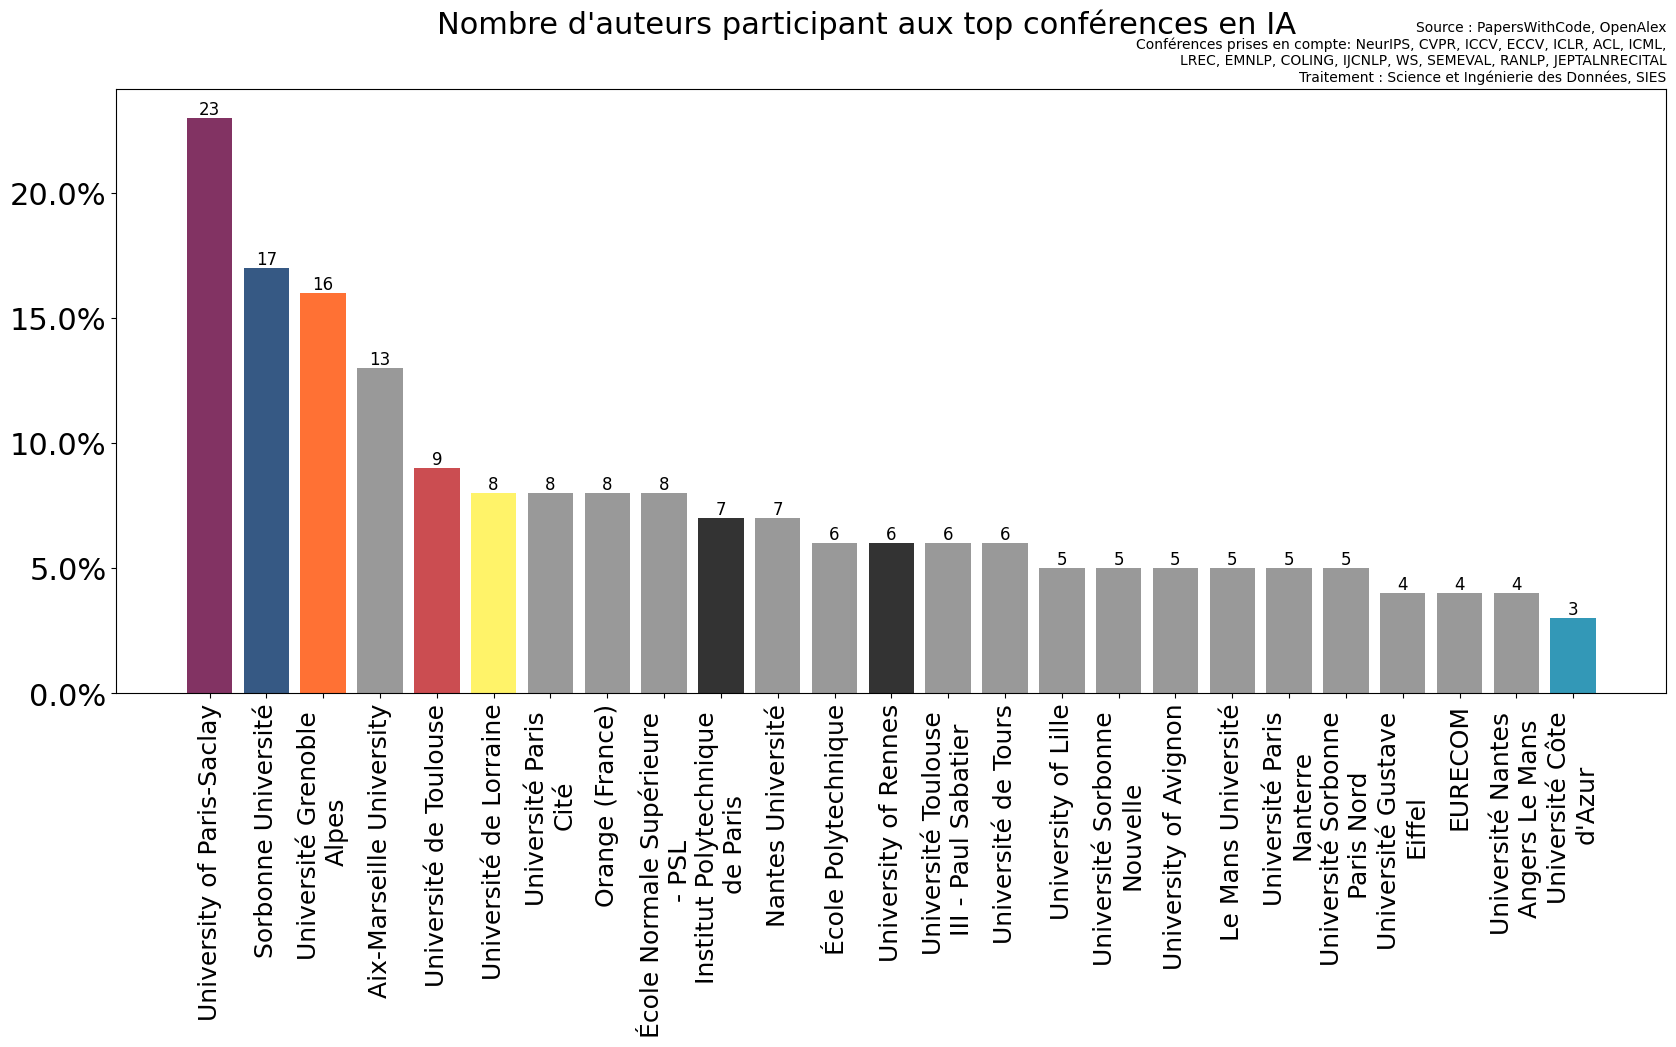

In [211]:
fig, ax = plt.subplots(figsize=(20,8), dpi=100)

ax.bar([e['label'] for e in top_etab_filtered], top_authors, 
       alpha=0.8, color=colors
      )
plt.suptitle(f"Nombre d'auteurs participant aux top conférences en IA")
plt.title('Source : PapersWithCode, OpenAlex\nConférences prises en compte: NeurIPS, CVPR, ICCV, ECCV, ICLR, ACL, ICML,\nLREC, EMNLP, COLING, IJCNLP, WS, SEMEVAL, RANLP, JEPTALNRECITAL\nTraitement : Science et Ingénierie des Données, SIES', size=10, loc='right')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xticklabels([e['label'] for e in top_etab_filtered], rotation='vertical', fontsize=SMALL_SIZE)
for i in range(len(top_authors)):
    plt.text(i, top_authors[i]+0.15, str(top_authors[i]), ha = 'center', fontsize=12)